In [21]:
import awkward as ak
import os
import numpy as np
import uproot
import nbimporter
import import_ipynb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from numpy.lib.recfunctions import structured_to_unstructured
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.ensemble import RandomForestRegressor
import DeepSetNeuralNetArchitecture
from DeepSetNeuralNetArchitecture import Predicted_Bhad_px_means
from DeepSetNeuralNetArchitecture import Predicted_Bhad_px_uncertainties
from xgboost import XGBRegressor

In [2]:
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'red'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [3]:
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPoints_2/DeepNetWeights&Biases.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)


In [4]:
#The data is being stored in a tree datastructure. 
#We access the charm root using this command
tree = uproot.open("hffrag.root:CharmAnalysis")

In [5]:
MAXEVENTS = 1e20
MAXTRACKS = 32
LR = 1e-4

In [6]:
#Read in the data from the root file
track_features = ["AnalysisTracks_pt","AnalysisTracks_eta","AnalysisTracks_phi","AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi"]
features = tree.arrays(jet_features+track_features,entry_stop = MAXEVENTS)

In [7]:
#Select the events of interest
events = features[ak.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis = 1) > 0]

In [8]:
#Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))

#Select tracks from the events
tracks = events[track_features]

#Match the tracks to the jets
matchedtracks = tracks[DeepSetNeuralNetArchitecture.Match_Tracks(jets,tracks)]

#Pad and Flatten the data
matchedtracks = DeepSetNeuralNetArchitecture.flatten(matchedtracks, MAXTRACKS)

# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1)

print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1]))

#Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

#Fix the angles
jets = DeepSetNeuralNetArchitecture.pt_eta_phi_2_px_py_pz_jets(jets).to_numpy()
tracks_p = DeepSetNeuralNetArchitecture.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads = DeepSetNeuralNetArchitecture.pt_eta_phi_2_px_py_pz_jets(bhads)
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)

The number of jets to train on is:  141329
There are 3 outputs
There are 32 inputs
(68143, 32, 3)
(68143, 32, 5)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:99: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [9]:
#Load the training and validation data
X_train = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_train_data.npy")
X_valid = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/X_valid_data.npy")
y_train = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_train_data.npy")
y_valid = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/TrainingAndValidationData/y_valid_data.npy")
X_train_event, y_train_event = np.array([X_train[0]]), np.array([y_train[0]])
X_valid_event, y_valid_event = np.array([X_valid[0]]), np.array([y_valid[0]])
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_train_event),np.shape(y_train_event))

(54514, 32, 8) (54514, 3)
(1, 32, 8) (1, 3)


In [10]:
#Cyclical Learning Rate Scheduler:
steps_per_epoch = len(X_train)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate = 1e-4,
maximal_learning_rate = 1e-3,
scale_fn = lambda x: 0.90 ** x,
step_size = 2.0 * steps_per_epoch
)
optimizer = tf.keras.optimizers.Nadam(LR,clipnorm = 1.0)

# Builds the deep neural network
track_layers = [100,100,100,100]
jet_layers = [100,100,100,100]
DeepNet = DeepSetNeuralNetArchitecture.DeepSetNeuralNetwork(
    [len(track_features)]+track_layers, jet_layers,3,optimizer)

2022-12-20 08:44:22.542958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-20 08:44:22.542995: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-20 08:44:22.543018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2022-12-20 08:44:22.570928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
Bhads_px_momentum = np.mean(bhads[:,0])
Bhads_px_uncertainty = np.mean(bhads[:,3])

NameError: name 'np' is not defined

In [ ]:
Figure,ax = plt.subplots()
ax.set_title("Mean Px Momentum of jets prediction verus the mean Px Momentum of the Bhads jets")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Px Momenta of jets")
ax.plot(Bhads_px_momentum)
ax.plot(Predicted_Bhad_px_means)

In [ ]:
Figure,ax = plt.subplots()
ax.set_title("Mean Px Momentum Uncertainty of jets prediction verus the mean Px Momentum Uncertaintyof the Bhads jets")
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Px Momenta Uncertainty of jets")
ax.plot(Bhads_px_momentum)
ax.plot(Predicted_Bhad_px_means)

<AxesSubplot:>

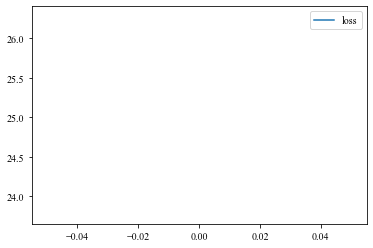

In [11]:
DeepNet.load_weights(latest_DeepNet)
history_df = pd.read_csv("/home/physics/phujdj/DeepLearningParticlePhysics/history.csv")
np.log(history_df.loc[:, ["loss"]]).plot()
#Specify the neural network's optimizer and loss function
#loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
#print("The Loaded DeepNet has loss: ", round(loss,3))

In [12]:
prediction = DeepNet.predict(X_train_event)
print(prediction,y_train_event)
print(DeepNet.evaluate(X_train_event,y_train_event))

1/1 [==============================] - 0s 389ms/step
[[nan nan nan nan nan nan nan nan nan]] [[-85204.02824177 -68300.12259415 112933.04017868]]
1/1 [==============================] - 0s 271ms/step - loss: nan - Normal_Accuracy_Metric: nan - Root_Mean_Square_Metric: nan
[nan, nan, nan]


In [13]:
# Have the model predict the total momentum of the b tracks
predictions = DeepNet.predict(tracks)
predictions_train = DeepNet.predict(X_train)
predictions_valid = DeepNet.predict(X_valid)

426/426 [==============================] - 7s 15ms/step


In [14]:
# Output the first 10 guesses
print(predictions[:10])
print(np.shape(predictions))
print(bhads[:10])

[[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
(68143, 9)
[[  48855.56531144  128363.19160447  124938.01790683]
 [    843.45625286   77133.74792279  179693.16123271]
 [ -77645.8243511   -61246.03310984 -543946.69198392]
 [  14105.86372119  -28270.27862345    3567.73767912]
 [  19637.04494914  -28563.57486597  -26376.60331503]
 [ -30646.74970554   73222.93169604  -33788.85654509]
 [  60390.6973391    56997.81220067  325654.38520138]
 [ -72178.99726066  -68222.88070912 -175227.83127402]
 [  45643.80086696  -12164.6048607    17055.60480696]
 [ -75954.8230627   124772.33655723   66689.33314863]]


In [15]:
# Output the first 10 guesses
print(predictions_train[:10])
print(np.shape(predictions_train))
print(y_train[:10])

[[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
(54514, 9)
[[ -85204.02824177  -68300.12259415  112933.04017868]
 [  21691.09368661   11842.91751954   45277.72048297]
 [  15571.72779763  -66472.08592353    6899.34870592]
 [ -50816.55445023    7618.0969351  -101465.86546643]
 [  20687.93480627  -58839.0355176    -8682.85456323]
 [  18138.3859071   -65356.5338003  -209410.67028055]
 [  72821.9023284   134862.45855944  -16929.38344943]
 [ -81988.15400436  -20298.50719717   83801.36223244]
 [ -72553.39163227   -1096.16967172   83493.72456024]
 [  36122.75026133   21199.83626714   22405.20209631]]


In [16]:
# Output the first 10 guesses
print(predictions_valid[:10])
print(np.shape(predictions_valid))
print(y_valid[:10])

[[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
(13629, 9)
[[  11053.67819198   61647.07193126   83832.50039463]
 [ -35044.3317476   -44009.02278432  -34334.56826614]
 [ -62001.1779407  -138788.09023189  199375.24973739]
 [ -25916.14867036  -33275.74151987   39004.31062974]
 [ -15172.34910067   -8123.43782507   -7910.70979374]
 [   1863.40863869   39229.06127929  -66961.7381647 ]
 [ -46489.94782909   11182.79841591  -20550.24740849]
 [ 100149.11559155  -61697.90534614  253099.20682779]
 [  38762.47981852   23764.01046198   86222.69029349]
 [  38962.46057489   42734.28718585   56322.02381744]]


In [17]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_px_train = (predictions_train[:, 0] - y_train[:,0])
pull_px_train = error_px_train/np.exp(predictions_train[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,0]),np.max(predictions_train[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_px_train), np.std(error_px_train))
print("The mean/std for the pull", np.mean(pull_px_train), np.std(pull_px_train))


nan nan
Mean and standard deviation
The mean/std for the ppred - ptrue:  nan nan
The mean/std for the pull nan nan


In [18]:
print(np.shape(predictions_valid))
print(np.shape(X_valid))
print(np.shape(y_valid))

(13629, 9)
(13629, 32, 8)
(13629, 3)


In [19]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_px_valid = (predictions_valid[:, 0] - y_valid[:,0])
pull_px_valid = error_px_valid/np.exp(predictions_valid[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,0]),np.max(predictions_valid[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_px_valid), np.std(error_px_valid))
print("The mean/std for the pull", np.mean(pull_px_valid), np.std(pull_px_valid))

nan nan
Mean and standard deviation
The mean/std for the ppred - ptrue:  nan nan
The mean/std for the pull nan nan


In [20]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_px = (predictions[:, 0] - bhads[:,0])
pull_px = error_px/np.exp(predictions[:, 3])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions[:,0]),np.max(predictions[:,0]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_px), np.std(error_px))
print("The mean/std for the pull", np.mean(pull_px), np.std(pull_px))

nan nan
Mean and standard deviation
The mean/std for the ppred - ptrue:  nan nan
The mean/std for the pull nan nan


In [21]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_py_train = (predictions_train[:, 1] - y_train[:,1])
pull_py_train = error_py_train/np.exp(predictions_train[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,1]),np.max(predictions_train[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_py_train), np.std(error_py_train))
print("The mean/std for the pull", np.mean(pull_py_train), np.std(pull_py_train))

3.0093017 3.1082191
Mean and standard deviation
The mean/std for the ppred - ptrue:  183.68536503341622 65564.38450255577
The mean/std for the pull 0.007210578981802716 2.5745708043119016


In [22]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_py_valid = (predictions_valid[:, 1] - y_valid[:,1])
pull_py_valid = error_py_valid/np.exp(predictions_valid[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,1]),np.max(predictions_valid[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_py_valid), np.std(error_py_valid))
print("The mean/std for the pull", np.mean(pull_py_valid), np.std(pull_py_valid))

2.8140152 3.108174
Mean and standard deviation
The mean/std for the ppred - ptrue:  -180.1667058179938 65089.7443737973
The mean/std for the pull -0.0070768207995783915 2.5559310978812277


In [23]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_py = (predictions[:, 1] - bhads[:,1])
pull_py = error_py/np.exp(predictions[:, 4])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,1]),np.max(predictions_valid[:,1]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_py), np.std(error_py))
print("The mean/std for the pull", np.mean(pull_py), np.std(pull_py))

2.8140152 3.108174
Mean and standard deviation
The mean/std for the ppred - ptrue:  79.79046484890499 65422.41896611621
The mean/std for the pull -0.09669102323395881 1.1314022280025204


In [24]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pz_train = (predictions_train[:, 2] - y_train[:,2])
pull_pz_train = error_pz_train/np.exp(predictions_train[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_train[:,2]),np.max(predictions_train[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pz_train), np.std(error_pz_train))
print("The mean/std for the pull", np.mean(pull_pz_train), np.std(pull_pz_train))

4.2342715 4.2547336
Mean and standard deviation
The mean/std for the ppred - ptrue:  972.7057599727327 198155.22296140206
The mean/std for the pull 0.01741315099466791 3.547175186115228


In [25]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pz_valid = (predictions_valid[:, 2] - y_valid[:,2])
pull_pz_valid = error_pz_valid/np.exp(predictions_valid[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions_valid[:,2]),np.max(predictions_valid[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pz_valid), np.std(error_pz_valid))
print("The mean/std for the pull", np.mean(pull_pz_valid), np.std(pull_pz_valid))

4.2220435 4.2637696
Mean and standard deviation
The mean/std for the ppred - ptrue:  8.914644293680873 196541.87868753087
The mean/std for the pull 0.00016097770160706636 3.5183018672487654


In [26]:
#Assesses the error and pull in the transverse momentum predictions by the neural network
error_pz = (predictions[:, 2] - bhads[:,2])
pull_pz = error_pz/np.exp(predictions[:, 5])

# Compares and constrasts the true and predicted momentums
print(np.min(predictions[:,2]),np.max(predictions[:,2]))

print("Mean and standard deviation")
print("The mean/std for the ppred - ptrue: ", np.mean(error_pz), np.std(error_pz))
print("The mean/std for the pull", np.mean(pull_pz), np.std(pull_pz))

2.6826658 11.587735
Mean and standard deviation
The mean/std for the ppred - ptrue:  685.4401285662684 197673.16719617162
The mean/std for the pull -0.12258544834308291 1.4134701956773152


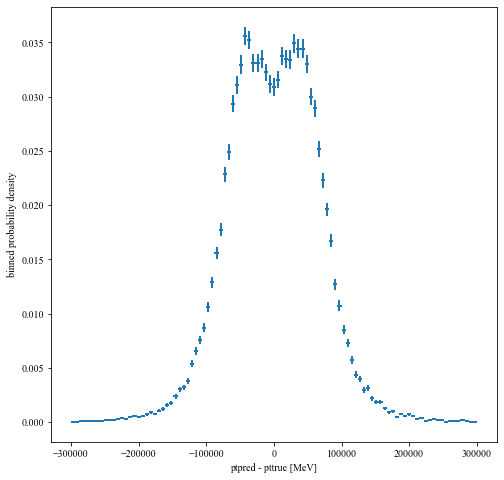

In [27]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_px_train, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

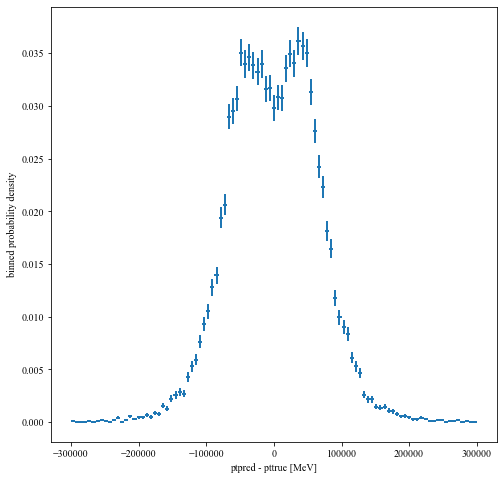

In [28]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_px_valid, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

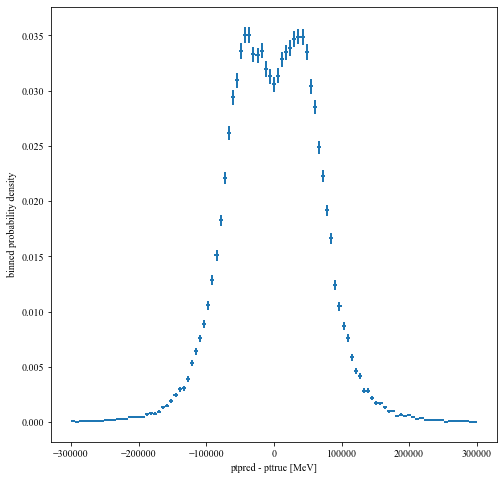

In [29]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_px, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

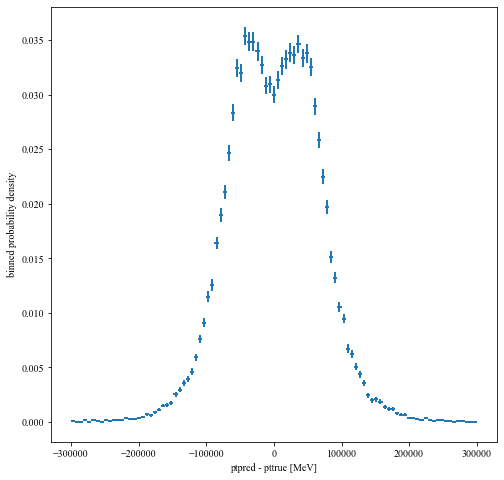

In [30]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_py_train, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

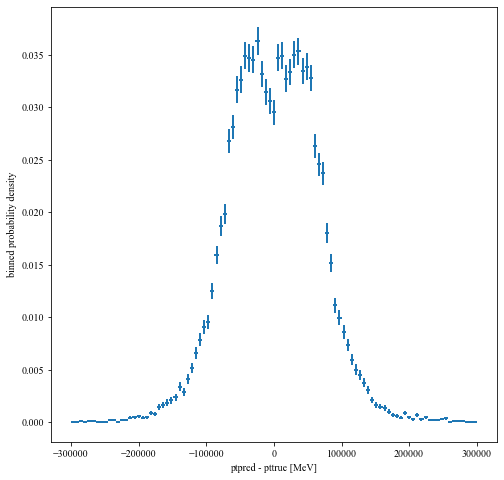

In [31]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_py_valid, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

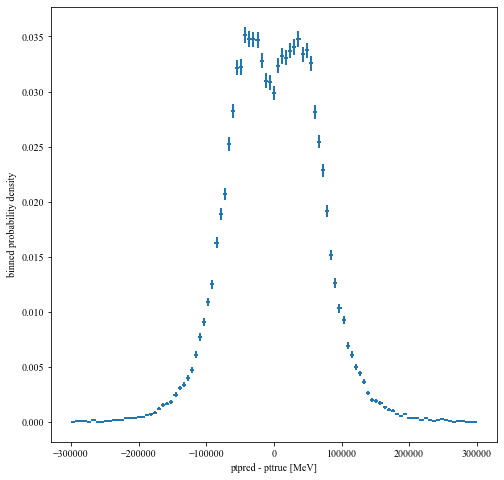

In [32]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_py, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

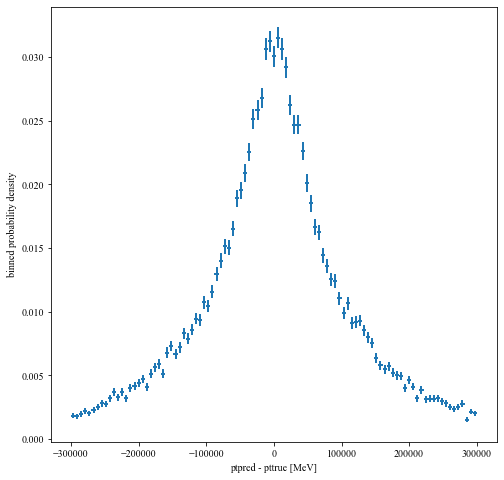

In [33]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pz_train, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

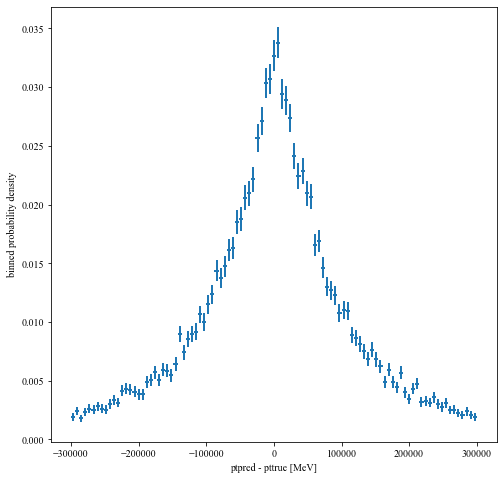

In [34]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pz_valid, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

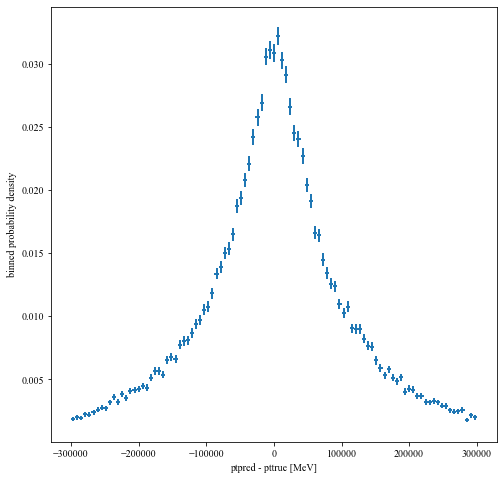

In [35]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(error_pz, fixedbinning(-300000, 300000, 100),
                    xlabel="ptpred - pttrue [MeV]")
fig

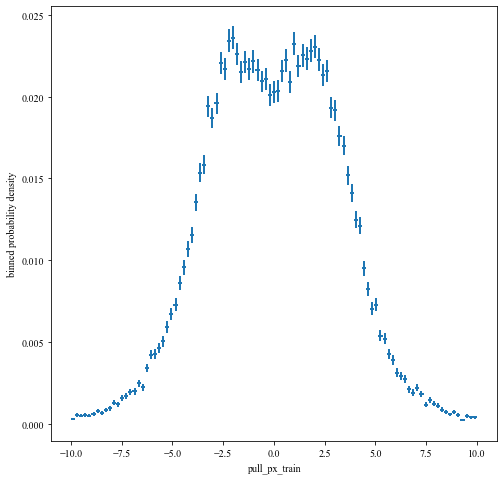

In [65]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_px_train, fixedbinning(-10.0, 10.0, 100),
                    xlabel="pull_px_train")
fig

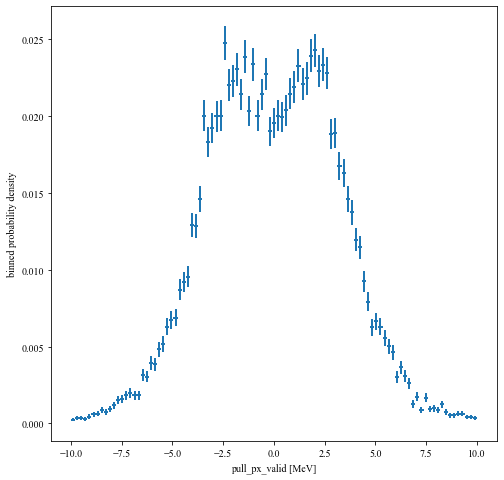

In [66]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_px_valid, fixedbinning(-10.0, 10.0, 100),
                    xlabel="pull_px_valid [MeV]")
fig

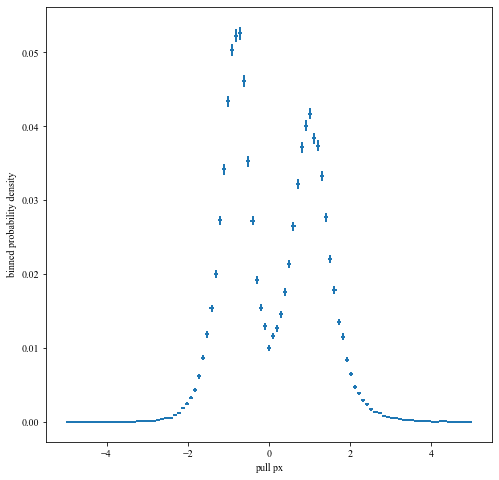

In [39]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_px, fixedbinning(-5, 5, 100),
                    xlabel="pull px")
fig

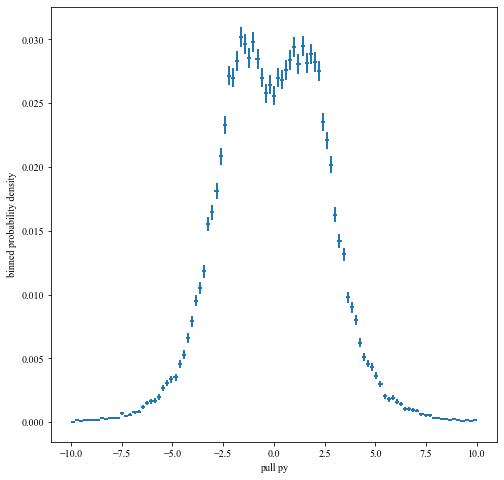

In [40]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_py_train, fixedbinning(-10, 10, 100),
                    xlabel="pull py")
fig

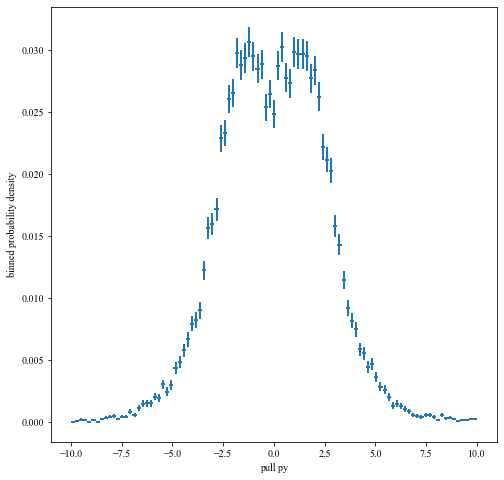

In [41]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_py_valid, fixedbinning(-10, 10, 100),
                    xlabel="pull py")
fig

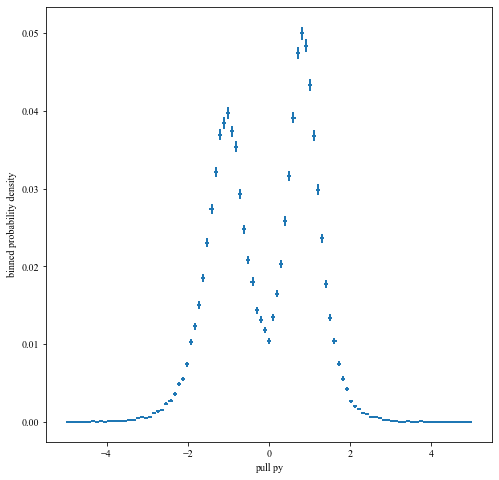

In [67]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_py, fixedbinning(-5.0, 5.0, 100),
                    xlabel="pull py")
fig

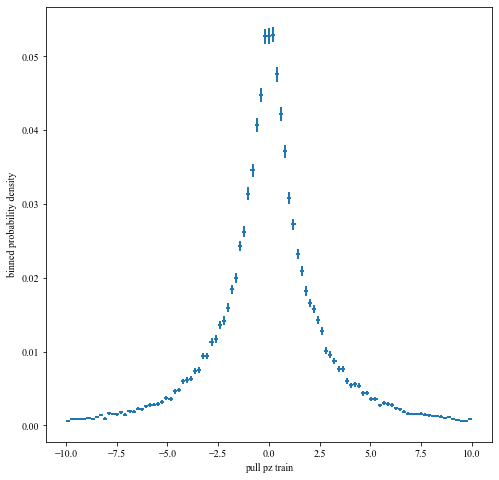

In [61]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pz_train, fixedbinning(-10, 10, 100),
                    xlabel="pull pz train")
fig

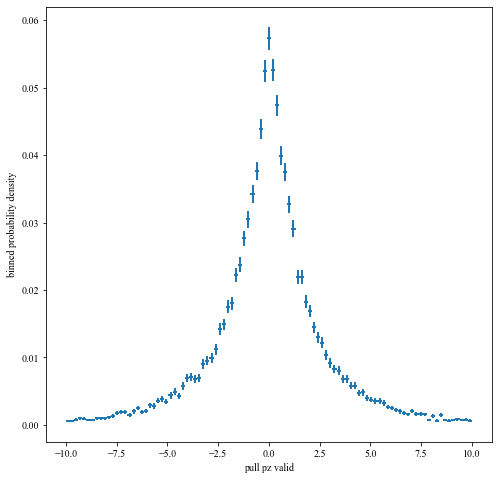

In [60]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pz_valid, fixedbinning(-10, 10, 100),
                    xlabel="pull pz valid")
fig

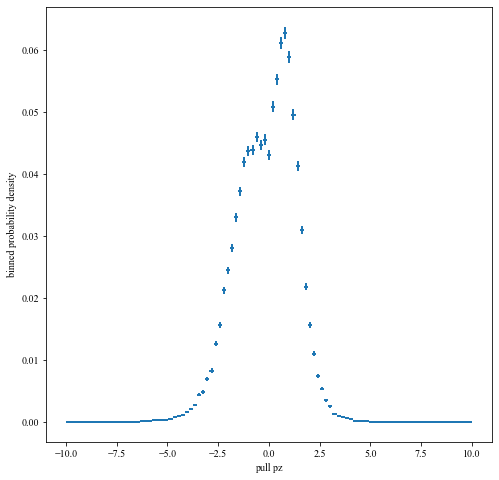

In [59]:
#Plot the distribution of tranverse momentum error.
fig = binneddensity(pull_pz, fixedbinning(-10, 10, 100),
                    xlabel="pull pz")
fig

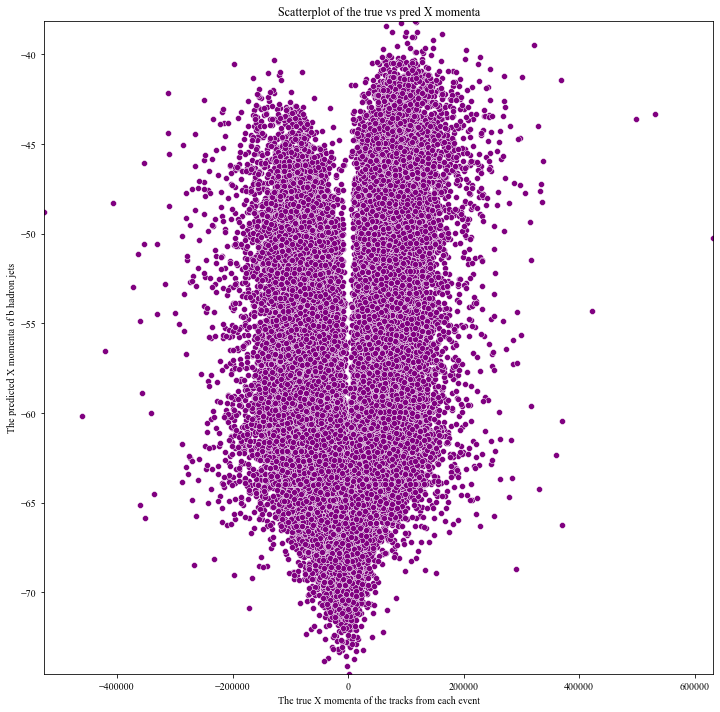

In [48]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,0],
    y = predictions[:,0],
    color = "purple"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(bhads[:,0]),np.max(bhads[:,0])])
ax.set_ylim([np.min(predictions[:,0]),np.max(predictions[:,0])])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.show()

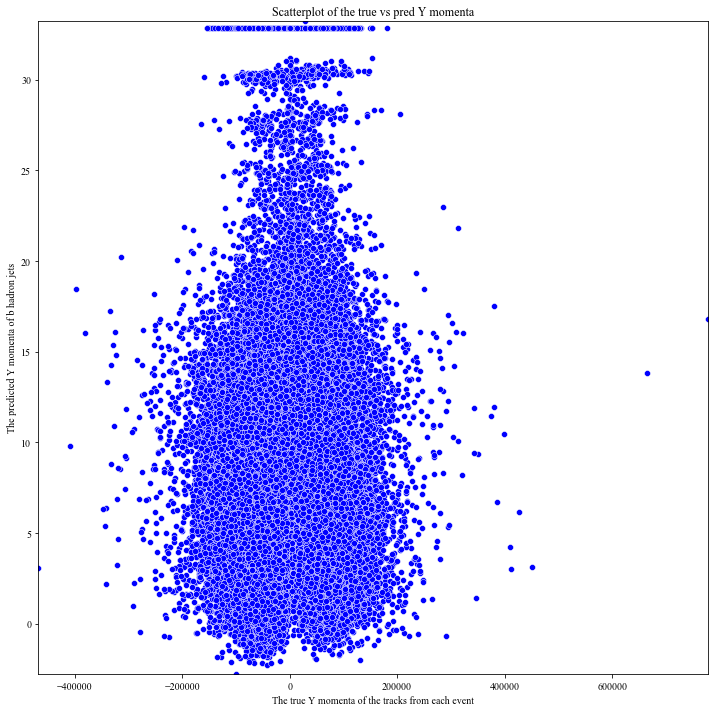

In [49]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,1],
    y = predictions[:,1],
    color = "blue"
)
ax.set_title("Scatterplot of the true vs pred Y momenta")
ax.set_xlim([np.min(bhads[:,1]),np.max(bhads[:,1])])
ax.set_ylim([np.min(predictions[:,1]),np.max(predictions[:,1])])
ax.set_xlabel("The true Y momenta of the tracks from each event")
ax.set_ylabel("The predicted Y momenta of b hadron jets")
plt.show()

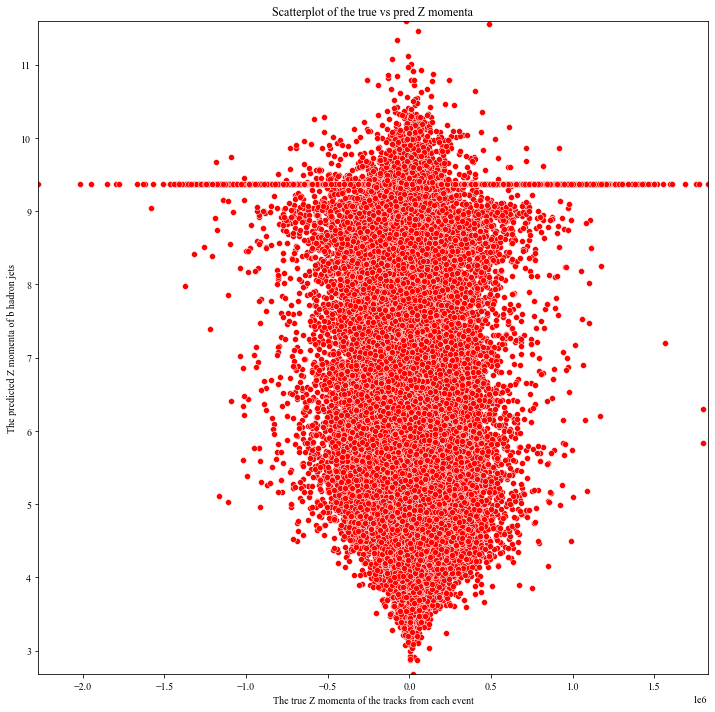

In [50]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,2],
    y = predictions[:,2],
    color = "red"
)
ax.set_title("Scatterplot of the true vs pred Z momenta")
ax.set_xlim([np.min(bhads[:,2]),np.max(bhads[:,2])])
ax.set_ylim([np.min(predictions[:,2]),np.max(predictions[:,2])])
ax.set_xlabel("The true Z momenta of the tracks from each event")
ax.set_ylabel("The predicted Z momenta of b hadron jets")
plt.show()

In [51]:
#Evaluate the entire performance of the model
loss = DeepNet.evaluate(tracks,bhads,verbose = 2)
print("The Loaded DeepNet has loss: ", loss,3)

2130/2130 - 4s - loss: 34.9064 - Normal_Accuracy_Metric: 100.1176 - 4s/epoch - 2ms/step
The Loaded DeepNet has loss:  [34.90641403198242, 100.11763000488281] 3


In [76]:
from sklearn.model_selection import train_test_split
X_1= np.ma.masked_equal(tracks[:,:,0],-999)
print(X_1.mask)
print(np.shape(X_1),np.shape(bhads[:,0]))
X_train_ml,X_valid_ml,y_train_ml,y_valid_ml = train_test_split(X_1,bhads[:,0],random_state = 42)
print(np.shape(X_train_ml),np.shape(y_train_ml))

[[False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 ...
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]
 [False False False ...  True  True  True]]
(68143, 32) (68143,)
(51107, 32) (51107,)


In [77]:
ForestRegressor = RandomForestRegressor(n_estimators = 200, max_depth = 14, random_state = 42)
ForestRegressor.fit(X_train_ml,y_train_ml)

RandomForestRegressor(max_depth=14, n_estimators=200, random_state=42)

In [78]:
ForestRegressor.score(X_valid_ml,y_valid_ml)

0.8415397070348073

In [79]:
Predictions = ForestRegressor.predict(X_valid_ml)
mean = np.mean(Predictions)
std = np.std(Predictions)
Pull_RandomForest = (Predictions - y_valid_ml)/std
mean2 = np.mean(Pull_RandomForest)
std2 = np.std(Pull_RandomForest)
print(mean,std)
print(mean2,std2)

3.69865119071791 58620.8749146641
7.449027130136629e-05 0.44075502734461997


In [80]:
from sklearn.metrics import mean_absolute_error
predictions = ForestRegressor.predict(X_valid_ml)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_valid_ml)))

Mean Absolute Error: 17077.52449086644


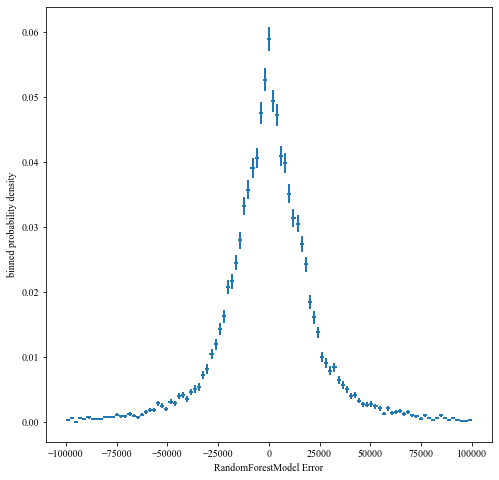

In [81]:
binneddensity(Predictions - y_valid_ml, fixedbinning(-100000,100000,100), xlabel ="RandomForestModel Error")

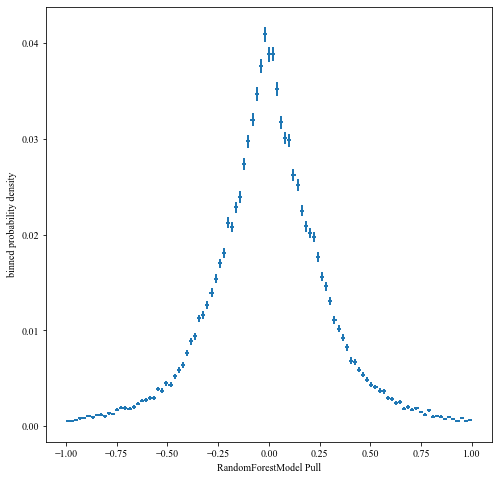

In [28]:
binneddensity(Pull_RandomForest, fixedbinning(-1,1,100), xlabel ="RandomForestModel Pull")

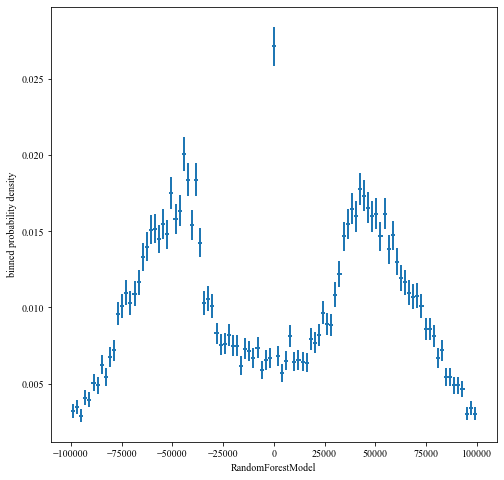

In [82]:
binneddensity(Predictions, fixedbinning(-100000,100000,100), xlabel ="RandomForestModel")

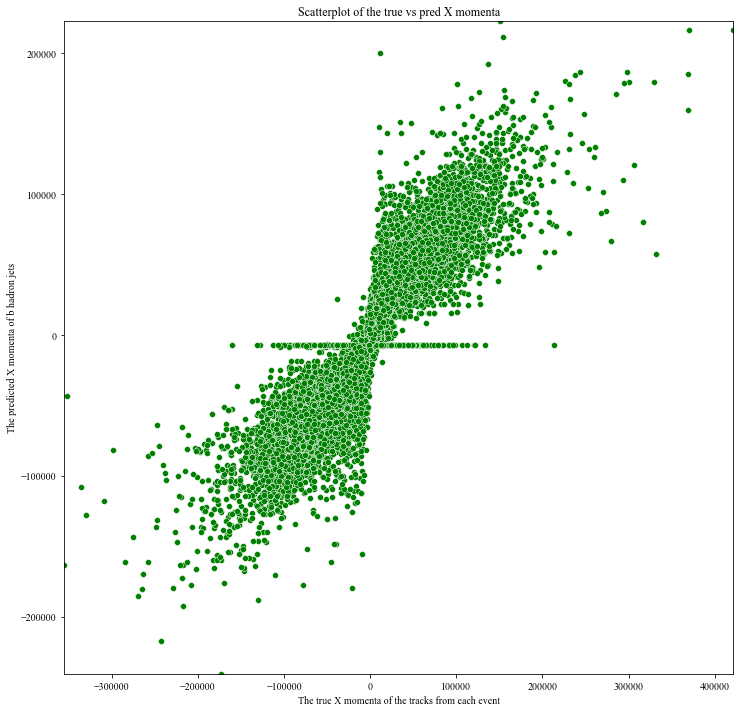

In [123]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_valid_ml,
    y = Predictions,
    color = "green"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(y_valid_ml),np.max(y_valid_ml)])
ax.set_ylim([np.min(Predictions),np.max(Predictions)])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.show()

In [122]:
xgbooster = XGBRegressor(n_estimators = 6000, num_parallel_tree = 1,early_stopping_rounds= 5, learning_rate = 1e-3)
xgbooster.fit(X_train_ml,y_train_ml, eval_set = [(X_valid_ml,y_valid_ml)], verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=5, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=6000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [124]:
from sklearn.metrics import mean_absolute_error
predictions = xgbooster.predict(X_valid_ml)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_valid_ml)))

Mean Absolute Error: 16890.130577286753


In [125]:
predictions[:10]

array([ 28082.963, -42100.16 , -47444.15 , -28579.664, -49129.016,
        12184.125, -62514.01 ,  62853.746,  35350.492,  36762.29 ],
      dtype=float32)

In [126]:
Predictions = xgbooster.predict(X_valid_ml)
mean = np.mean(Predictions)
std = np.std(Predictions)
Pull_xgbooster = (Predictions - y_valid_ml)/std
mean2 = np.mean(Pull_xgbooster)
std2 = np.std(Pull_xgbooster)
print(mean,std)
print(mean2,std2)

32.080162 58740.223
0.000557508323335815 0.4322171890612809


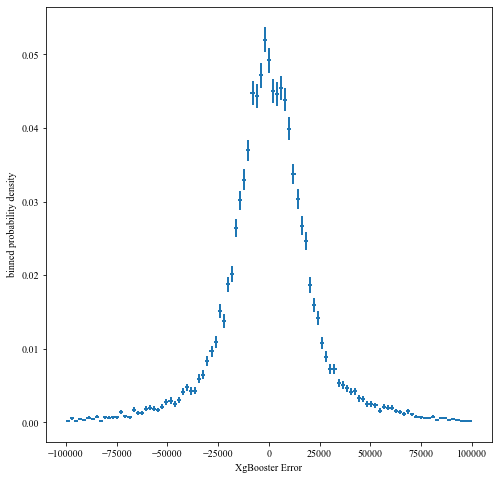

In [127]:
binneddensity(Predictions - y_valid_ml, fixedbinning(-100000,100000,100), xlabel ="XgBooster Error")

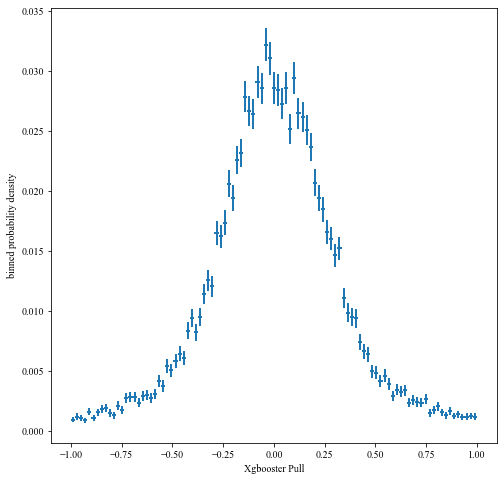

In [128]:
binneddensity(Pull_xgbooster, fixedbinning(-1,1,100), xlabel ="Xgbooster Pull")

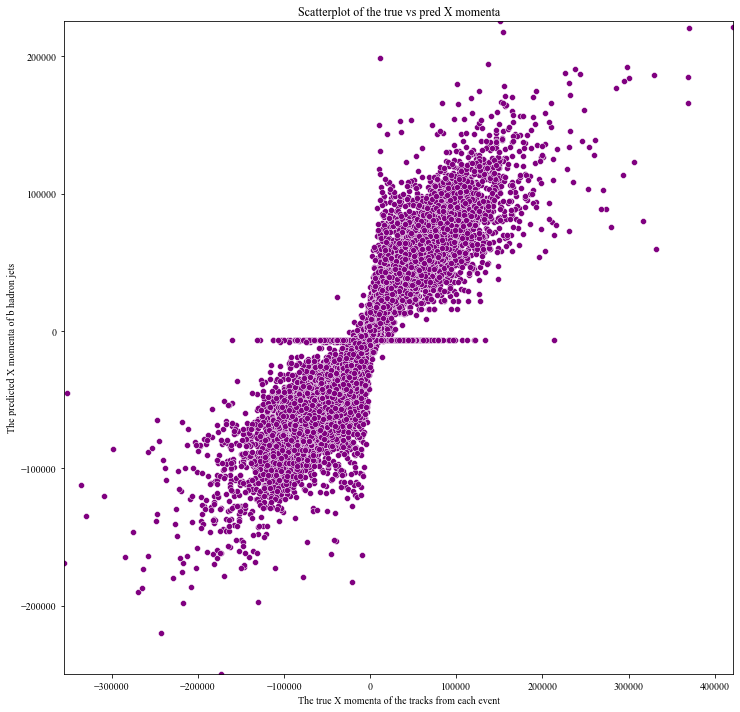

In [129]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_valid_ml,
    y = Predictions,
    color = "purple"
)
ax.set_title("Scatterplot of the true vs pred X momenta")
ax.set_xlim([np.min(y_valid_ml),np.max(y_valid_ml)])
ax.set_ylim([np.min(Predictions),np.max(Predictions)])
ax.set_xlabel("The true X momenta of the tracks from each event")
ax.set_ylabel("The predicted X momenta of b hadron jets")
plt.show()